This notebook contains the demo codes for AMATH 482/582 Lec 3.

In [2]:
!pip3.9 install matplotlib
!pip3.9 install numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.2 MB 5.7 MB/s            
     |████████████████████████████████| 890 kB 102.5 MB/s            
     |████████████████████████████████| 1.6 MB 100.7 MB/s            
     |████████████████████████████████| 97 kB 17.5 MB/s            
     |████████████████████████████████| 40 kB 14.7 MB/s            
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import matplotlib.pyplot as plt


First we plot the function we wish to study, 
$$f(x, s, k_1, k_2, l) = \exp \left( - \frac{x^2}{2 s^2} \right) \cos \left(\frac{\pi k_1x}{l}\right) + 0.25*\sin\left(\frac{\pi k_2 x}{l}\right) $$

In [4]:
def f(x,s, k1, k2, l):
  
  val = np.exp( - x**2/(2*s**2))*np.cos(k1*x*np.pi/l) + 0.25*np.sin(k2*x*np.pi/l)

  return val


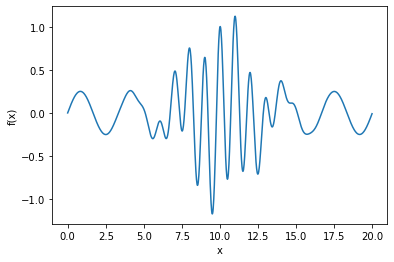

In [7]:
# plot the function on interval [0, 2*L]

L = 10 

N_grid = 2**10 # number of points in the grid

grid = np.linspace(0, 2*L, N_grid+1)
grid = grid[0:N_grid]

s =2
k1 =20
k2 = 6

f_vals = f(grid - 10, s, k1, k2, L)

# plotting f

plt.plot(grid, f_vals)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()



We now compute the FFT of this function and plot its real and imaginary parts. 

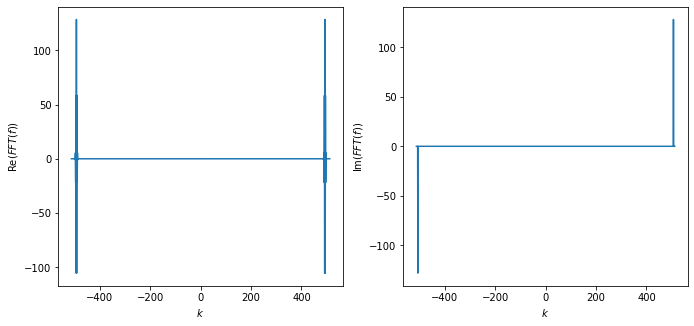

In [8]:
f_fft = np.fft.fft(f_vals)

freq_grid =np.linspace(- N_grid/2, N_grid/2, N_grid)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 5))

fig.tight_layout(pad=3.0)

ax0.plot(freq_grid, f_fft.real)
ax0.set_xlabel(r'$k$')
ax0.set_ylabel(r'Re($FFT(f)$)')


ax1.plot(freq_grid, f_fft.imag)
ax1.set_xlabel(r'$k$')
ax1.set_ylabel(r'Im($FFT(f)$)')


plt.show()

This isn't right. Modify N_grid to see that the FFT values change. This is a problem because we expect that as N_grid increases the FFT output converges to the DFT. Also, we seem to be getting peak amplitudes at high frequencies but looking at the signal we know it is mosly low frequency. These are technical issues due to the way the FFT algorithm is implemented and how we defined the DFT in lectures. 

First we fix the issue with the ordering of FFT. This is due to the fact that Numpy (and pretty much all other implementations of FFT) order the output frequencies like ([see manual](https://numpy.org/doc/stable/reference/routines.fft.html))
$$k \in (0, 1, 2, \dots, N/2-1, -N/2, -N/2+1, \dots, -1)$$
There is an easy fix for this in the 'fftshift' function. 


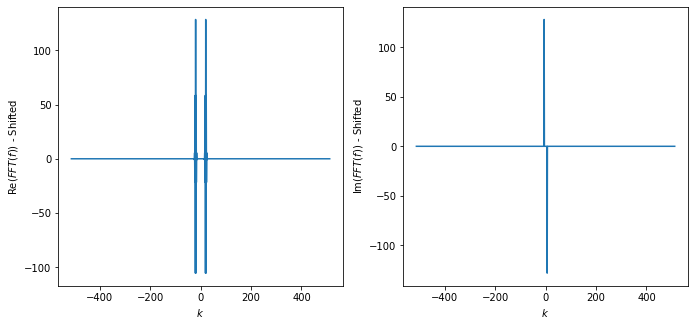

In [9]:
# the fftshift function fixes the issue with the peak amplitudes appearing at the wrong frequencies.

f_fft_shifted = np.fft.fftshift(f_fft)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 5))

fig.tight_layout(pad=3.0)

ax0.plot(freq_grid, f_fft_shifted.real)
ax0.set_xlabel(r'$k$')
ax0.set_ylabel(r'Re($FFT(f)$) - Shifted')

ax1.plot(freq_grid, f_fft_shifted.imag)
ax1.set_xlabel(r'$k$')
ax1.set_ylabel(r'Im($FFT(f)$) - Shifted')

plt.show()

Next we need to fix the scaling following the lecture notes. 

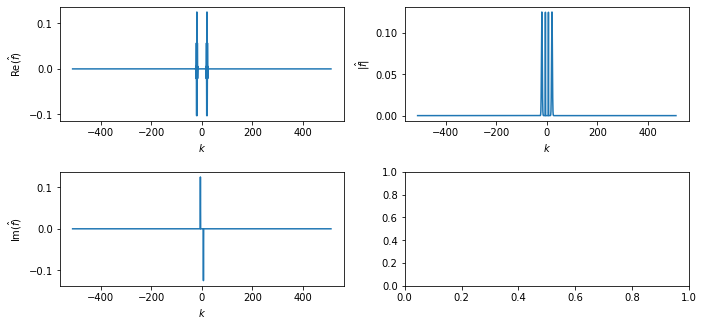

In [10]:
f_hat = (1/N_grid)*f_fft_shifted

fig, (ax0, ax1) = plt.subplots(2,2, figsize=(10, 5))

fig.tight_layout(pad=3.0)

ax0[0].plot(freq_grid, f_hat.real)
ax0[0].set_xlabel(r'$k$')
ax0[0].set_ylabel(r'Re($\hat{f}$)')

ax1[0].plot(freq_grid, f_hat.imag)
ax1[0].set_xlabel(r'$k$')
ax1[0].set_ylabel(r'Im($\hat{f}$)')

ax0[1].plot(freq_grid, np.abs(f_hat))
ax0[1].set_xlabel(r'$k$')
ax0[1].set_ylabel(r'$|\hat{f}|$')

plt.show()


Let us now demonstrate how FFT can be used for function approximation. This is a stepping stone to filtering. 

Idea is simple, we wish to approximate some function $g: [0, 2L] \to \mathbb{R}$ with another function $h: [0, 2L] \to \mathbb{R}$ that has few non-zero Fourier coefficients. 

As an example we take the heaviside function. 
$$g(x) = \left\{\begin{aligned}
 &0 &  x \le L \\
&1  & x > L
\end{aligned}\right.$$

In [7]:
def g(x,L): 
  return (x >= L)


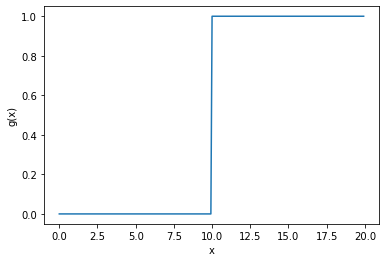

In [8]:
# plot g

g_vals = g(grid, L)

plt.plot(grid, g_vals)
plt.xlabel('x')
plt.ylabel('g(x)')
plt.show()


We now compute the FFT of $g$. 

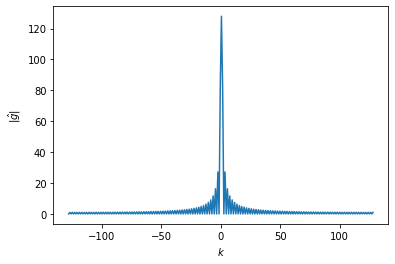

In [9]:
g_hat = np.fft.fftshift(np.fft.fft(g_vals))

plt.plot(freq_grid, np.abs(g_hat))
plt.xlabel(r'$k$')
plt.ylabel(r'$|\hat{g}|$')

plt.show()

We now construct $h$ by defining $\hat{h}$ as 
$$\hat{h}_k = \left\{ \begin{aligned}
&\hat{g}_k &  |k| \le 50 \\ 
 &0 & |k| > 50
\end{aligned}\right.$$

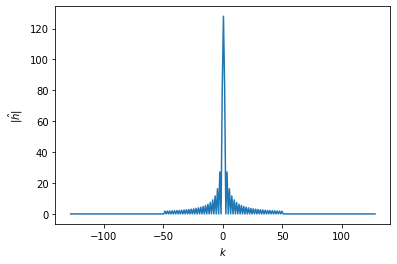

In [10]:
filter = (np.abs(freq_grid) <= 50)
filter =filter.astype(float)

h_hat = filter*g_hat

plt.plot(freq_grid, np.abs(h_hat))
plt.xlabel(r'$k$')
plt.ylabel(r'$|\hat{h}|$')

plt.show()

Finally we get $h$ using the inverse fourier transform. 

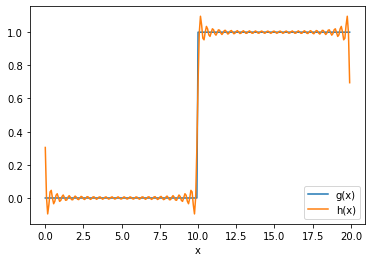

In [11]:
h_vals = np.fft.ifft( np.fft.ifftshift(h_hat) )

h_vals = np.real(h_vals) # to get rid of negligble complex entries.

plt.plot(grid, g_vals, label="g(x)")
plt.plot(grid, h_vals, label="h(x)")
plt.xlabel('x')
plt.legend(loc="lower right")
plt.show()

What we just did, and as my naming suggests, is called filtering. We filtered the fourier transform of $g$ to only keep the frequency components below a certain threshold and set the rest to zero. In essence we made $h$ to be a "simpler" version of $g$ from the lenz of Fourier analysis.

Filtering is fundamental in signal processing and it is something you have to do everytime you have a signal in the real world since noise is always present. 
Let us demonstrate this with our function $f$. 

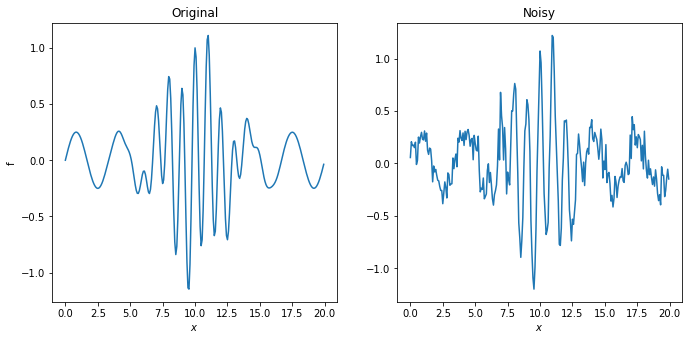

In [12]:
# Create noisy version of f

f_noisy_vals =  f_vals + 0.1*np.random.randn(N_grid)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 5))

fig.tight_layout(pad=3.0)

ax0.plot(grid, f_vals)
ax0.set_xlabel(r'$x$')
ax0.set_ylabel(r'f')
ax0.set_title('Original')

ax1.plot(grid, f_noisy_vals)
ax1.set_xlabel(r'$x$')
ax1.set_title('Noisy')

plt.show()

We now take the FFT of the noisy signal and define a Gaussian filter.

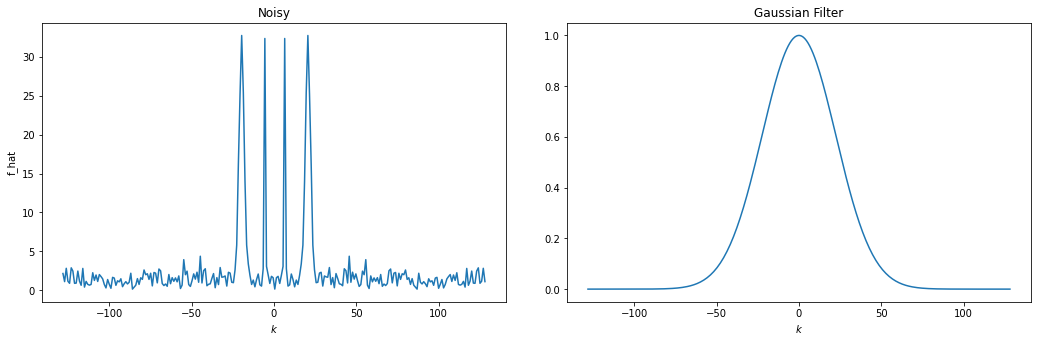

In [13]:
f_noisy_hat = np.fft.fftshift( np.fft.fft( f_noisy_vals))

Gaussian_filter_vals = np.exp( - (0.001*freq_grid**2) )

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15, 5))

fig.tight_layout(pad=3.0)

ax0.plot(freq_grid , np.abs(f_noisy_hat))
ax0.set_xlabel(r'$k$')
ax0.set_ylabel(r'f_hat')
ax0.set_title('Noisy')

ax1.plot(freq_grid, Gaussian_filter_vals)
ax1.set_xlabel(r'$k$')
ax1.set_title('Gaussian Filter')



plt.show()


Apply filter to FFT of noisy singal and reconstruct.

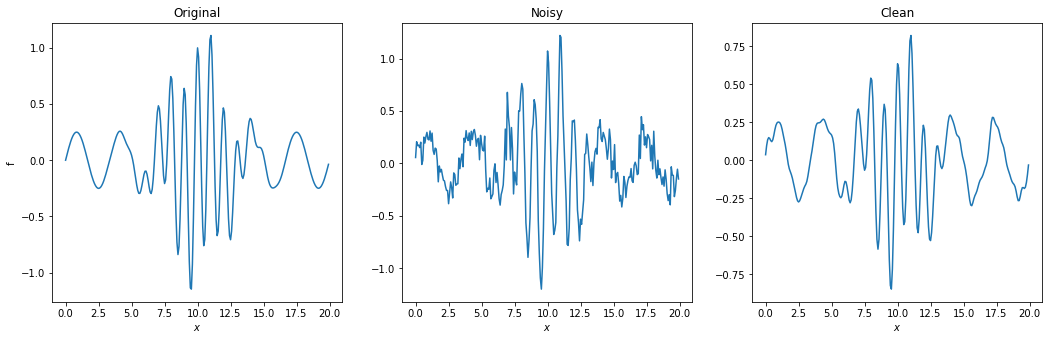

In [14]:
f_clean_vals = np.fft.ifft( np.fft.ifftshift( f_noisy_hat*Gaussian_filter_vals ) )

f_clean_vals = np.real(f_clean_vals)

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15, 5))

fig.tight_layout(pad=3.0)

ax0.plot(grid, f_vals)
ax0.set_xlabel(r'$x$')
ax0.set_ylabel(r'f')
ax0.set_title('Original')

ax1.plot(grid, f_noisy_vals)
ax1.set_xlabel(r'$x$')
ax1.set_title('Noisy')

ax2.plot(grid, f_clean_vals)
ax2.set_xlabel(r'$x$')
ax2.set_title('Clean')

plt.show()